## Definition

### Problem Statement  

The goal is to forecast the demand for bikes in dependency of weather conditions like outside temperature and calendric informations e.g. holidays. These information and the demand structure is provided in a set with two years of daily historic data.  
The demand is given as the total daily demand and as a split for registered users and casual users. To increase the quality of the prediction registered user demand and casual user demand will be predicted separately in step two.  
   
> http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html  
> https://github.com/tensorflow/skflow/blob/master/g3doc/api_docs/python/estimators.md  
> http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html  
> http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from math import sqrt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from sklearn.model_selection import cross_val_score, train_test_split

## Analysis

In [3]:
# Fetching Dataset

bike_data = pd.read_csv("day.csv", header=0)

print("Data read successfully!")

Data read successfully!


In [4]:
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Data Exploration

In [5]:
# Extracting

feature_cols = bike_data.columns[:-3]  # all columns but last are features
target_col = bike_data.columns[-1]  # last column is the target

print ("Feature column(s):\n{}\n".format(feature_cols))
print ("Target column:\n{}".format(target_col))

Feature column(s):
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

Target column:
cnt


In [6]:
#### Function to Calculate Profit

In [7]:
def profit(y,y_cap,revenue=3,loanCost=2):
    return revenue * np.minimum(y[::1], y_cap[::1]) - loanCost * y_cap[::1]
    

#### Markdown:  Function to Calculate Cost


In [8]:
def cost (y_cap, loanCost):
    return loanCost * y_cap[::1]

#### Function to Calculate Profit as percentage of total expenditure

In [9]:
def profit_percentage(y,y_cap, revenue, loanCost):
    return ((revenue * np.minimum(y[::1], y_cap[::1]) - loanCost * y_cap[::1]).sum() / (loanCost * y_cap[::1]).sum() ) * 100

#### Function to Convert from percentage to Actual Prediction

In [10]:
def convertToPrediction(data,percentage_predictions):
    demand = np.around(data + (np.multiply(data, percentage_predictions)/100))
    demand[demand <0 ] = 0
    return demand

##### RMSLE Scorer
One common way to evaluate regression model is through calculating MSE or RMSE. In this particular project , the metric to evaluate our model is Root Mean Square Logarithmic Error (RMSLE). RMSLE is particularly helpful when you want to penalize an under-predicted estimate greater than an over-predicted estimate.

In [11]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Base Model

#### For the base model the demand for today is the previous days demand. 

In [12]:
y_actual = bike_data[target_col][365:731]  # corresponding targets
y_actual = y_actual.reset_index(drop = True)

In [13]:
y_staged = y_actual.copy()

In [14]:
data = []
data.insert(0, bike_data[target_col][364])
data.insert(0, bike_data[target_col][363])

In [15]:
y_predicted_df = pd.concat([pd.DataFrame(data), y_staged], ignore_index=True)

In [16]:
y_predicted_df.drop(y_predicted_df.tail(2).index,inplace=True)

In [17]:
y_predicted = y_predicted_df[0]


##### Calculate Base Model Profit

In [18]:
print(profit(y_actual,y_predicted).sum())

1442972


In [19]:
print("cost is:" + str(cost(y_predicted,2).sum()) )
print("profit is:" + str(profit(y_actual,y_predicted).sum()))
print("profit percentage is:" + str(profit_percentage(y_actual,y_predicted, 3, 2)))

cost is:4101070
profit is:1442972
profit percentage is:35.18525653061274


In [20]:
#### Alternate cost Model 1

In [21]:
print("cost is:" + str(cost(y_predicted,2).sum()) )
print("profit is:" + str(profit(y_actual,y_predicted,revenue = 2.2,loanCost=2 ).sum()))
print("profit percentage is:" + str(profit_percentage(y_actual,y_predicted, 2.2, 2)))

cost is:4101070
profit is:-35439.19999999969
profit percentage is:-0.8641452108839813


In [22]:
#### Alternate cost Model 2
print("cost is:" + str(cost(y_predicted,2).sum()) )
print("profit is:" + str(profit(y_actual,y_predicted,revenue = 8,loanCost=2 ).sum()))
print("profit percentage is:" + str(profit_percentage(y_actual,y_predicted, 8, 2)))

cost is:4101070
profit is:10683042
profit percentage is:260.4940174149673


In [23]:
#### Alternate cost Model 3
print("cost is:" + str(cost(y_predicted,2).sum()) )
print("profit is:" + str(profit(y_actual,y_predicted,revenue = 5,loanCost=2 ).sum()))
print("profit percentage is:" + str(profit_percentage(y_actual,y_predicted, 5, 2)))

cost is:4101070
profit is:5139000
profit percentage is:125.30876088435457


#### Dataset with percentage change

In [24]:
X_test = X_raw_test[cols].values.tolist()
y_test_df = X_raw_test[['target']]
y_test = y_test_df['target'].tolist()

NameError: name 'X_raw_test' is not defined

In [25]:
data = pd.read_csv("processed_Data.csv", header=0)
data['instant'] = data['instant'] % 30
X_raw_train = data[0:359]
X_raw_test  = data[359:]

In [26]:
cols =[
       "season__1","season__2","season__3","season__4","season__5",
       "weathersit__1","weathersit__2","weathersit__3","weathersit__4","weathersit__5",
        "cnt__1",
        "atemp","hum","windspeed",
        "mnth","instant","holiday","weekday","workingday",
        "moving_avg_weekly_cnt"]     

In [27]:
X_train = X_raw_train[cols].values.tolist()
y_train_df = X_raw_train[['demand_pc_inc']]
y_train = y_train_df['demand_pc_inc'].tolist()

In [28]:
X_test = X_raw_test[cols].values.tolist()
y_test_df = X_raw_test[['demand_pc_inc']]
y_test = y_test_df['demand_pc_inc'].tolist()

In [29]:
data_cnt = data['cnt']

In [30]:
actual_predictions = data_cnt[359:].values

In [31]:
y_for_calculations = data_cnt[357:723].values

### Algorithms and Techniques

##### Ensemble Methods

Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods can be divided into two groups: sequential ensemble methods where the base learners are generated sequentially (e.g. AdaBoost) and parallel ensemble methods where the base learners are generated in parallel (e.g. Random Forest). The basic motivation of sequential methods is to exploit the dependence between the base learners since the overall performance can be boosted by weighing previously mislabeled examples with higher weight. The basic motivation of parallel methods is to exploit independence between the base learners since the error can be reduced dramatically by averaging.

In [32]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [33]:
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

##### Implementation
The regressors are trained using randomized search and cross-validation to identify the area of the best parameters. Then a grid search is used to tune parameter values of the regressor functions.

http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html
http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html

#### Boosting
Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were mis-classified by earlier rounds. The predictions are then combined through a weighted majority vote (classification) or a weighted sum (regression) to produce the final prediction. The principal difference between boosting and the committee methods such as bagging is that base learners are trained in sequence on a weighted version of the data.

###### Adaptive Boosting

The algorithm below describes the most widely used form of boosting algorithm called AdaBoost, which stands for adaptive boosting.

In [34]:
### ADA Boost Regressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn import pipeline,metrics,grid_search

#regressor = RandomForestRegressor(random_state = 0, max_depth = 30, n_estimators = 500, max_features = 'log2')
regressor = AdaBoostRegressor()
estimator_ada = pipeline.Pipeline(steps = [       
    ('model_fitting', regressor)
    ]
)
estimator_ada.fit(X_train, y_train)
pred_ada = estimator_ada.predict(X_test)
model_predictions_ada = convertToPrediction(y_for_calculations,pred_ada)
print(profit(actual_predictions,model_predictions_ada).sum())

1507731.0


In [35]:
num_est = [1, 2, 3, 10,50,100,200,300,500]
learning_rate = [0.01,0.1,0.5,1]
loss = ['linear', 'square', 'exponential']
params_dict={'n_estimators':num_est,'learning_rate': learning_rate,'loss':loss}
clf_ada=GridSearchCV(estimator=AdaBoostRegressor(),param_grid=params_dict,scoring='neg_mean_squared_error')
clf_ada.fit(X_train,y_train)
pred_ada=clf_ada.predict(X_test)
model_predictions_ada = convertToPrediction(y_for_calculations,pred_ada)
print(profit(actual_predictions,model_predictions_ada).sum())

1475448.0


In [36]:
print("Best params: ", clf_ada.best_params_)

Best params:  {'learning_rate': 1, 'loss': 'square', 'n_estimators': 1}


In [40]:
regressor = AdaBoostRegressor(n_estimators = 200, loss = 'square')
estimator_ada = pipeline.Pipeline(steps = [       
    ('model_fitting', regressor)
    ]
)
estimator_ada.fit(X_train, y_train)
pred_ada = estimator_ada.predict(X_test)
model_predictions_ada = convertToPrediction(y_for_calculations,pred_ada)
print(profit(actual_predictions,model_predictions_ada).sum())

1528561.0


In [41]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_ada))

RMSLE Value:  0.4781617842632507


In [44]:
###
print("cost is:" + str(cost(model_predictions_ada,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_ada).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_ada, 3, 2)))

cost is:3831566.0
profit is:10462106.0
profit percentage is:273.050392450502


In [45]:
#### Alternate cost Model 1
print("cost is:" + str(cost(model_predictions_ada,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_ada,revenue = 2.2,loanCost=2 ).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_ada,2.2 , 2)))

cost is:3831566.0
profit is:99193.80000000032
profit percentage is:2.588857923888048


In [46]:
#### Alternate cost Model 2
print("cost is:" + str(cost(model_predictions_ada,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_ada,revenue = 8,loanCost=2 ).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_ada,8,2)))

cost is:3831566.0
profit is:10462106.0
profit percentage is:273.050392450502


In [129]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostRegressor(n_estimators=n_est)
    scores = cross_val_score(ada_clf, X_test, y_test, cv=3, scoring='neg_mean_squared_error')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

#### Gradient Tree Boosting
It is generally believed that boosting based algorithms like Gradient Boosting and XGBoost performs better than algorithms based on bagging. So its time to test how boosting algorithms can help us in improving our test score.

In [96]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

estimator_gbr = pipeline.Pipeline(steps = [       
    ('model_fitting', gbr)
    ]
)
estimator_gbr.fit(X_train, y_train)
pred_gbr = estimator_gbr.predict(X_test)
model_predictions_gbr = convertToPrediction(y_for_calculations,pred_gbr)
print(profit(actual_predictions,model_predictions_gbr).sum())

1581354.0


In [97]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_gbr))

RMSLE Value:  0.46912477237024686


In [99]:
num_est = [1, 2, 3, 10,50,100,200,300,500]
learning_rate = [0.01,0.1,0.5,1]
loss = ['ls', 'lad', 'huber', 'quantile']
max_depth = [1,3,5,10,20]
params_dict={'n_estimators':num_est,'learning_rate': learning_rate,'loss':loss, 'max_depth': max_depth}
clf_gbr=GridSearchCV(estimator=GradientBoostingRegressor(),param_grid=params_dict,scoring='neg_mean_squared_error')
clf_gbr.fit(X_train,y_train)
pred_gbr=clf_gbr.predict(X_test)
model_predictions_gbr = convertToPrediction(y_for_calculations,pred_gbr)
print(profit(actual_predictions,model_predictions_gbr).sum())

1574795.0


In [100]:
print("Best params: ", clf_gbr.best_params_)

Best params:  {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 500}


In [110]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate = 0.1, loss = 'lad', max_depth =  3, n_estimators =  500)

estimator_gbr = pipeline.Pipeline(steps = [       
    ('model_fitting', gbr)
    ]
)
estimator_gbr.fit(X_train, y_train)
pred_gbr = estimator_gbr.predict(X_test)
model_predictions_gbr = convertToPrediction(y_for_calculations,pred_gbr)
print(profit(actual_predictions,model_predictions_gbr).sum())

1586358.0


In [111]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_gbr))

RMSLE Value:  0.44077420589976285


In [291]:
print("cost is:" + str(cost(model_predictions_gbr,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_gbr).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_gbr, 3, 2)))

cost is:3417336.0
profit is:1586358.0
profit percentage is:46.420896277100056


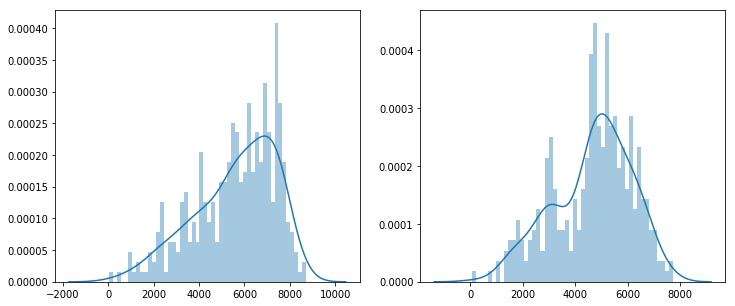

In [136]:
import seaborn as sn
fig,(ax1,ax2)= plt.subplots(ncols=2)
#plotting two figures

fig.set_size_inches(12,5)
#dimensions of each figure

sn.distplot(actual_predictions,ax=ax1,bins=50)
#plotting the original test data on axis 1

sn.distplot(model_predictions_gbr,ax=ax2,bins=50)
#plotting predicted values of GBM

#### Bagging
Bagging stands for bootstrap aggregation. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble: $$
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
$$

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

##### Random Forest Regressor
In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e. a bootstrap sample) from the training set. In addition, instead of using all the features, a random subset of features is selected, further randomizing the tree.

As a result, the bias of the forest increases slightly, but due to the averaging of less correlated trees, its variance decreases, resulting in an overall better model.

In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import pipeline,metrics,grid_search

#regressor = RandomForestRegressor(random_state = 0, max_depth = 30, n_estimators = 500, max_features = 'log2')
regressor = RandomForestRegressor()
estimator_rf = pipeline.Pipeline(steps = [       
    ('model_fitting', regressor)
    ]
)
estimator_rf.fit(X_train, y_train)
pred_rf = estimator_rf.predict(X_test)
model_predictions_rf = convertToPrediction(y_for_calculations,pred_rf)
print(profit(actual_predictions,model_predictions_rf).sum())

1594543.0


In [138]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_gbr))

RMSLE Value:  0.44077420589976285


In [139]:

#for random forest regresion.
no_of_test=[10,20,30,100,200,500]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2'],'max_depth':[2,3,5,10,20,30]}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_error')
clf_rf.fit(X_train,y_train)
pred_rf=clf_rf.predict(X_test)
model_predictions_rf = convertToPrediction(y_for_calculations,pred_rf)
print(profit(actual_predictions,model_predictions_rf).sum())

1547574.0


In [142]:
print("Best params: ", clf_rf.best_params_)

Best params:  {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 30, 'n_jobs': -1}


In [175]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import pipeline,metrics,grid_search

regressor = RandomForestRegressor(max_depth = 30, n_estimators = 30)

estimator_rf = pipeline.Pipeline(steps = [       
    ('model_fitting', regressor)
    ]
)
estimator_rf.fit(X_train, y_train)
pred_rf = estimator_rf.predict(X_test)
model_predictions_rf = convertToPrediction(y_for_calculations,pred_rf)
print(profit(actual_predictions,model_predictions_rf).sum())

1597493.0


In [176]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_gbr))

RMSLE Value:  0.44077420589976285


In [292]:
print("cost is:" + str(cost(model_predictions_rf,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_rf).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_rf, 3, 2)))

cost is:3659800.0
profit is:1597493.0
profit percentage is:43.649734958194436


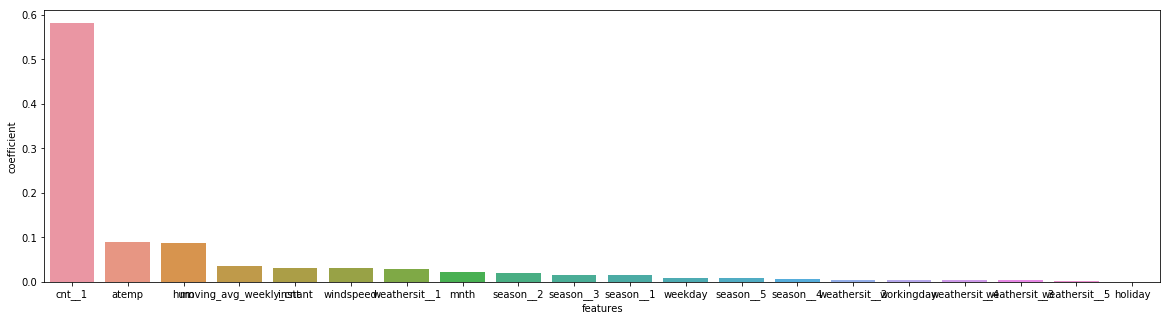

In [184]:
# Feature Importance By Random Forest
features = pd.DataFrame()
features['features'] = X_raw_train[cols].columns
features['coefficient'] = regressor.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)

#### Bagging Regressor
A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [242]:
### Bagging Regressor

from sklearn.ensemble import BaggingRegressor
from sklearn import pipeline,metrics,grid_search

regressor = BaggingRegressor()
estimator_bagging = pipeline.Pipeline(steps = [       
    ('model_fitting', regressor)
    ]
)
estimator_bagging.fit(X_train, y_train)
pred_bagging = estimator_bagging.predict(X_test)
model_predictions_bagging = convertToPrediction(y_for_calculations,pred_bagging)
print(profit(actual_predictions,model_predictions_bagging).sum())


1589684.0


In [211]:
from sklearn.tree import DecisionTreeRegressor
br1 = DecisionTreeRegressor( max_depth=1)
br2 = KNeighborsRegressor(n_neighbors=1)    

bagging1 = BaggingRegressor(base_estimator=br1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingRegressor(base_estimator=br2, n_estimators=10, max_samples=0.8, max_features=0.8)

In [256]:
estimator_bagging = pipeline.Pipeline(steps = [       
    ('model_fitting', regressor)
    ]
)
estimator_bagging.fit(X_train, y_train)
pred_bagging = estimator_bagging.predict(X_test)
model_predictions_bagging = convertToPrediction(y_for_calculations,pred_bagging)
print(profit(actual_predictions,model_predictions_bagging).sum())

1595955.0


In [258]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_bagging))

RMSLE Value:  0.4506950947403924


In [293]:
print("cost is:" + str(cost(model_predictions_bagging,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_bagging).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_bagging, 3, 2)))

cost is:3705558.0
profit is:1595955.0
profit percentage is:43.06922196333184


#### Stacking
Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [266]:
pred_train_rf = estimator_rf.predict(X_train)
pred_train_gbr = estimator_gbr.predict(X_train)
pred_train_ada = estimator_ada.predict(X_train)
pred_train_bagging = estimator_bagging.predict(X_train)

In [267]:
stack = pd.DataFrame({'rf':pred_train_rf, 'gbr':pred_train_gbr, 'ada':pred_train_ada,
                      'bagging':pred_train_bagging,'true':y_train})

In [268]:
from tensorflow.contrib import learn
import tensorflow as tf

# Stacking multiple regressors using DNN
features_blend = learn.infer_real_valued_columns_from_input(stack[['rf','gbr','ada','bagging']])

# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build multi-layer DNN for regression
blend_nn = learn.DNNRegressor(feature_columns=features_blend, hidden_units=[50, 20], 
                              optimizer=adam, activation_fn=tf.nn.leaky_relu)
#                               config=learn.estimators.RunConfig(num_cores=8))
# Fit DNN
blend_nn.fit(x=stack[['rf','gbr','ada','bagging']], y=stack['true'], steps=8000, batch_size=256)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1242def28>, '_master': '', '_

INFO:tensorflow:loss = 74.12538, step = 301 (0.370 sec)
INFO:tensorflow:global_step/sec: 260.795
INFO:tensorflow:loss = 91.90328, step = 401 (0.384 sec)
INFO:tensorflow:global_step/sec: 250.473
INFO:tensorflow:loss = 81.04874, step = 501 (0.399 sec)
INFO:tensorflow:global_step/sec: 255.345
INFO:tensorflow:loss = 73.92787, step = 601 (0.391 sec)
INFO:tensorflow:global_step/sec: 255.864
INFO:tensorflow:loss = 65.6759, step = 701 (0.391 sec)
INFO:tensorflow:global_step/sec: 273.082
INFO:tensorflow:loss = 55.675564, step = 801 (0.366 sec)
INFO:tensorflow:global_step/sec: 271.676
INFO:tensorflow:loss = 52.914978, step = 901 (0.369 sec)
INFO:tensorflow:global_step/sec: 272.334
INFO:tensorflow:loss = 73.475006, step = 1001 (0.367 sec)
INFO:tensorflow:global_step/sec: 287.068
INFO:tensorflow:loss = 64.76602, step = 1101 (0.349 sec)
INFO:tensorflow:global_step/sec: 285.768
INFO:tensorflow:loss = 57.06091, step = 1201 (0.350 sec)
INFO:tensorflow:global_step/sec: 269.751
INFO:tensorflow:loss = 56

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1241eb080>, 'hidden_units': [50, 20], 'feature_columns': (_RealValuedColumn(column_name='', dimension=4, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': <tensorflow.python.training.adam.AdamOptimizer object at 0x1162bb710>, 'activation_fn': <function leaky_relu at 0x1210b2c80>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [270]:
# PREDICT: RF for Regression
y_test_rf = estimator_rf.predict(X_test).flatten().tolist()

# PREDICT: GBR 
y_test_gbr = estimator_gbr.predict(X_test).flatten().tolist()

# PREDICT: ADA
y_test_ada = estimator_ada.predict(X_test).flatten().tolist()

# PREDICT: BAGGING
y_test_bagging = estimator_bagging.predict(X_test).flatten().tolist()



In [271]:
new_stack = pd.DataFrame(data={'rf':y_test_rf, 'gbr':y_test_gbr,
                               'ada':y_test_ada,'bagging': y_test_bagging,
                               'true':y_test})

In [272]:
y_new_bl = list(blend_nn.predict(new_stack[['rf', 'gbr', 'ada','bagging']]))

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmp3tcjyar3/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [275]:
model_predictions_ensemble = convertToPrediction(y_for_calculations,y_new_bl)

In [276]:
w = [1, 1, 1, 1]  # weights
pred_agg = np.c_[pred_rf,pred_gbr,pred_ada,pred_bagging]
pred_avr = np.average(pred_agg, axis=1, weights=w)
model_predictions_avr = convertToPrediction(y_for_calculations,pred_avr)
print(profit(actual_predictions,model_predictions_avr).sum())

1607746.0


In [277]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_avr))

RMSLE Value:  0.44466405787899516


In [294]:
print("cost is:" + str(cost(model_predictions_avr,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_avr).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_avr, 3, 2)))

cost is:3658010.0
profit is:1607746.0
profit percentage is:43.95138340245106


In [297]:
### Alternate cost model

In [300]:
print("cost is:" + str(cost(model_predictions_ada,2).sum()) )
print("profit is:" + str(profit(actual_predictions,model_predictions_ada,revenue = 2.2).sum()))
print("profit percentage is:" + str(profit_percentage(actual_predictions,model_predictions_ada, 2.2, 2)))

cost is:3849350.0
profit is:90282.40000000033
profit percentage is:2.345393378102805
